<a href="https://www.kaggle.com/code/lakshmipriya190803/reddit-comments-analysis-using-nlp-and-dl?scriptVersionId=164666007" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Welcome :)

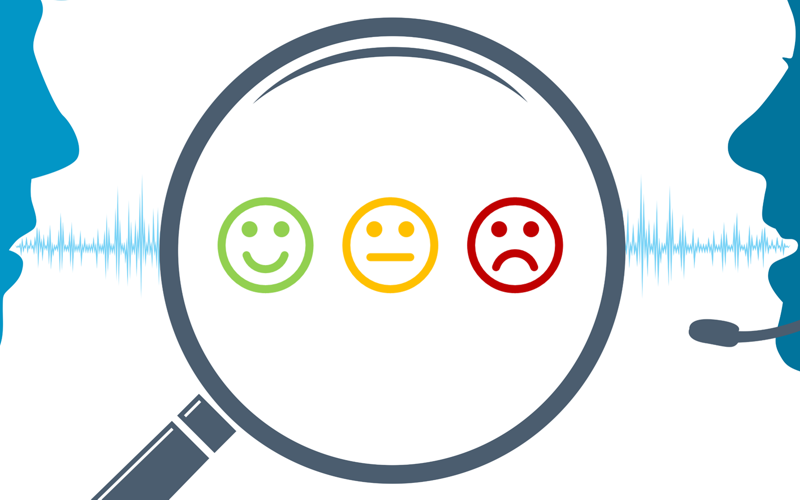

Let's explore Reddit Comments Sentiment Analysis using Machine Learning and Deep Learning. 

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is essential for effective sentiment analysis. It helps understand sentiment label distribution, identify text preprocessing needs, and select relevant features. EDA also addresses imbalanced classes, detects outliers, and visualizes data trends. This process enhances model interpretability and ensures robust sentiment analysis by informing decisions on preprocessing steps, feature selection, and model design.

In [1]:
!pip install vaderSentiment
!pip install twython
!pip install keras
!pip install np_utils
!pip install nltk
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 729.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=e490681847d71afe4fa1d70de09b78dba0ce15ae069bcc4f94b9c97ea48fe026
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.9

In [2]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [3]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.3 MB/s eta 0:00:00


In [4]:
import pandas as pd 
import numpy as np
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

from nltk.tokenize import RegexpTokenizer
import re
import string


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer


from keras.preprocessing import sequence, text
from tqdm import tqdm
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential


from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
#from keras.utils.module_utils import tensorflow as tf
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-02-28 08:58:44.527676: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 08:58:44.527790: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 08:58:44.527888: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 08:58:44.527972: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 08:58:44.528049: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 08:58:44.528254: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 08:58:44.528358: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [6]:
df_1 = pd.read_csv("/kaggle/input/chatgpt-reddit/chatgpt-reddit-comments.csv")
df_1.head(5)

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [7]:
df_1.describe()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
count,52413,52415,52415,52415,52415
unique,29712,52413,22596,51042,5
top,671,comment_id,t3_107vs7i,[deleted],r/ChatGPT
freq,4,3,239,661,29711


In [8]:
print(f"Null values ? \n{df_1.isnull().sum()}")

Null values ? 
Unnamed: 0           3
comment_id           1
comment_parent_id    1
comment_body         1
subreddit            1
dtype: int64


In [9]:
print("since we've got some null values, let's remove that first")
df_1.dropna(inplace = True)
df_1.isna().sum()
print(f"Null values ? \n{df_1.isnull().sum()}")

since we've got some null values, let's remove that first
Null values ? 
Unnamed: 0           0
comment_id           0
comment_parent_id    0
comment_body         0
subreddit            0
dtype: int64


so far we can see the first column just contains the index, we've got id of the person commenting, what they've commented and the subreddit, NO *labels*

there are so many patterns we could look for
is there any relation between the average sentiment of comments and subreddits?
how is the overall sentiment of comments

My overall focus is going to be on comments themselves so commenter's id will be irrelevant
Although one thing I might go on look further a person would be whether they were siding with the group and how many were like them or whether their opinions stayed constant throughout subreddits 
this will be something i would look at, at the very last obviously!


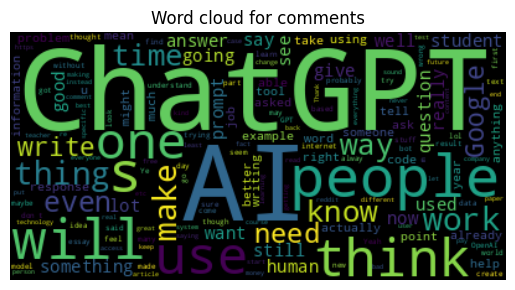

In [10]:
comments = df_1['comment_body']
text = ' '.join(comments.astype(str).tolist())

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud for comments")
plt.show()

## Data Preparation

Okay from now on I will be focusing entirely on the 'Comment body' 
We do not have labels so there's two things we could do:

1. Go unsupervised
2. Use sentiment analysers to give a rating to each comment based on lexicon

Let's try both and see where we go
Either way the data needs to be cleaned before we proceed further

## Applying Vader Sentiment Analysis to obtain Labels

VADER SENTIMENT ANALYSIS SCORES are affected by factors like punctuations,capitalization,preceeding-trigrams,degree modifiers,conjunctions etc.

So without Data Preparation, we will apply VADER 

We will first clean text data in the 'comment_body' column and then perform sentiment analysis using the VADER sentiment analysis tool. The sentiment analysis results can then be added as a new 'sentiment' column in the DataFrame.

In [11]:
len(df_1['comment_body'])

52412

In [12]:

def clean(text):
    # Remove URLs and website links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Replace consecutive whitespaces with a single whitespace
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Remove text within square brackets
    text = re.sub('\[.*?\]', '', text)
    # Remove newline characters
    text = re.sub('\n', '', text)
    # Remove words containing digits
    text = re.sub('\w*\d\w*', '', text)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    # Return the cleaned text
    return text

# Apply the 'clean' function to the 'comment_body' column of DataFrame df_1
df_1['comment_body'] = df_1['comment_body'].apply(lambda x: clean(x))

# Import the SentimentIntensityAnalyzer class from vaderSentiment library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# Initialize an empty list to store sentiment scores
scores = []

# Iterate over non-null rows of DataFrame df_1
for index, row in df_1.dropna().iterrows():
    # Calculate sentiment scores using VADER sentiment analysis
    score = analyser.polarity_scores(row['comment_body'])
    # Extract the compound score and append it to the scores list
    score = score['compound']
    scores.append(score)

# Initialize an empty list to store sentiment labels
sentiment = []

# Iterate over the scores and categorize the sentiment as Positive, Negative, or Neutral
for i in scores:
    if i >= 0.05:
        sentiment.append('Positive')
    elif i <= (-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')

# Convert the sentiment list into a Pandas Series
Sentiment_Comment = pd.Series(np.array(sentiment))

# Add the sentiment column to DataFrame df_1
df_1['sentiment'] = Sentiment_Comment



In [13]:
df_1.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit,sentiment
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,Negative
1,1,iztn0q0,t3_zj2aeu,I am so angry right now. I just wasted my tim...,r/ChatGPT,Negative
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Negative
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,Neutral
4,4,izu2as9,t3_zj2aeu,"Certified /, must-see moment. It really did sh...",r/ChatGPT,Negative


We have our classes now, lets prepare our features for sentiment analysis using supervised deep learning techniques

## Data Prep using Stemming and Lemmatizing 

In [14]:
df = df_1
df.drop(['Unnamed: 0', 'comment_id', 'comment_parent_id'], inplace = True, axis = 1)
df.head()

,comment_body,subreddit,sentiment
0,"I've been shocked for days now, I don't need c...",r/ChatGPT,Negative
1,I am so angry right now. I just wasted my tim...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Negative
3,"Worked on me, ngl.",r/ChatGPT,Neutral
4,"Certified /, must-see moment. It really did sh...",r/ChatGPT,Negative


In [15]:
#converting all text to lowercase
df['comment_body'] = df['comment_body'].str.lower()
df.head(5)

,comment_body,subreddit,sentiment
0,"i've been shocked for days now, i don't need c...",r/ChatGPT,Negative
1,i am so angry right now. i just wasted my tim...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks! just when...,r/ChatGPT,Negative
3,"worked on me, ngl.",r/ChatGPT,Neutral
4,"certified /, must-see moment. it really did sh...",r/ChatGPT,Negative


In [16]:
#cleaning and removing punctuations 
english_punctuations = string.punctuation

def cleaning_punctuations(text):
    translator = str.maketrans('','', english_punctuations)
    return text.translate(translator)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_punctuations(x))
df.head(5)

,comment_body,subreddit,sentiment
0,ive been shocked for days now i dont need clic...,r/ChatGPT,Negative
1,i am so angry right now i just wasted my time...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks just when ...,r/ChatGPT,Negative
3,worked on me ngl,r/ChatGPT,Neutral
4,certified mustsee moment it really did shock ...,r/ChatGPT,Negative


In [17]:
#cleaning and removing repeating characters:

def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_repeating_char(x))
df.head()

,comment_body,subreddit,sentiment
0,ive ben shocked for days now i dont ned clickbait,r/ChatGPT,Negative
1,i am so angry right now i just wasted my time...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks just when ...,r/ChatGPT,Negative
3,worked on me ngl,r/ChatGPT,Neutral
4,certified mustse moment it realy did shock me ...,r/ChatGPT,Negative


In [18]:
#cleaning and removing url's

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ', data)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_URLs(x))
df.head()

,comment_body,subreddit,sentiment
0,ive ben shocked for days now i dont ned clickbait,r/ChatGPT,Negative
1,i am so angry right now i just wasted my time...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks just when ...,r/ChatGPT,Negative
3,worked on me ngl,r/ChatGPT,Neutral
4,certified mustse moment it realy did shock me ...,r/ChatGPT,Negative


In [19]:
#cleaning and removing numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+','',data)

df['comment_body'] = df['comment_body'].apply(lambda x: cleaning_numbers(x))
df.head()

,comment_body,subreddit,sentiment
0,ive ben shocked for days now i dont ned clickbait,r/ChatGPT,Negative
1,i am so angry right now i just wasted my time...,r/ChatGPT,Negative
2,chatgpt karma whoring is here folks just when ...,r/ChatGPT,Negative
3,worked on me ngl,r/ChatGPT,Neutral
4,certified mustse moment it realy did shock me ...,r/ChatGPT,Negative


In [20]:
# tokenizing the comments

tokeniser = RegexpTokenizer(r'\w+')
df['comment_body'] = df['comment_body'].apply(tokeniser.tokenize)
df.head()

,comment_body,subreddit,sentiment
0,"[ive, ben, shocked, for, days, now, i, dont, n...",r/ChatGPT,Negative
1,"[i, am, so, angry, right, now, i, just, wasted...",r/ChatGPT,Negative
2,"[chatgpt, karma, whoring, is, here, folks, jus...",r/ChatGPT,Negative
3,"[worked, on, me, ngl]",r/ChatGPT,Neutral
4,"[certified, mustse, moment, it, realy, did, sh...",r/ChatGPT,Negative


### Stemming:

Stemming is the process of reducing a word to its base or root form by removing suffixes.


Example: The word "running" would be stemmed to "run," and "happily" would become "happi."


Stemming is more aggressive and faster, making it suitable for tasks where speed is crucial. However, it may result in words that are not actual words.

In [21]:
#Applying stemming

st = nltk.PorterStemmer()

def stemming_on_text(data):
    data = [st.stem(word) for word in data]
    return data

df['comment_body'] = df['comment_body'].apply(lambda x: stemming_on_text(x))

df.head()

,comment_body,subreddit,sentiment
0,"[ive, ben, shock, for, day, now, i, dont, ned,...",r/ChatGPT,Negative
1,"[i, am, so, angri, right, now, i, just, wast, ...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, is, here, folk, just, ...",r/ChatGPT,Negative
3,"[work, on, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, musts, moment, it, reali, did, shock...",r/ChatGPT,Negative


In [22]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [23]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


### Lemmatizing:

Lemmatization is the process of reducing a word to its base or root form, but it considers the word's meaning and context. It typically involves dictionary lookup to ensure that the resulting word is a valid one.

The word "better" would be lemmatized to "good," as it captures the intended meaning of the word

Lemmatization is more accurate than stemming but can be computationally expensive. It is suitable for applications where accuracy is critical, such as in information retrieval or search engines.

In [24]:
#lemmatizer 
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    data = [lm.lemmatize(word) for word in data]
    return data

df['comment_body'] = df['comment_body'].apply(lambda x: lemmatizer_on_text(x))
df.head()

,comment_body,subreddit,sentiment
0,"[ive, ben, shock, for, day, now, i, dont, ned,...",r/ChatGPT,Negative
1,"[i, am, so, angri, right, now, i, just, wast, ...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, is, here, folk, just, ...",r/ChatGPT,Negative
3,"[work, on, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, must, moment, it, reali, did, shock,...",r/ChatGPT,Negative


In [25]:
df.head()

,comment_body,subreddit,sentiment
0,"[ive, ben, shock, for, day, now, i, dont, ned,...",r/ChatGPT,Negative
1,"[i, am, so, angri, right, now, i, just, wast, ...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, is, here, folk, just, ...",r/ChatGPT,Negative
3,"[work, on, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, must, moment, it, reali, did, shock,...",r/ChatGPT,Negative


In [26]:
var1 = df.groupby('sentiment').count()['comment_body'].reset_index().sort_values(by='comment_body',ascending=False)
sns.set_style("white")
sns.set_palette("Set2")
var1.style.background_gradient()

,sentiment,comment_body
2,Positive,26335
1,Neutral,13363
0,Negative,12711


<Axes: xlabel='sentiment', ylabel='count'>

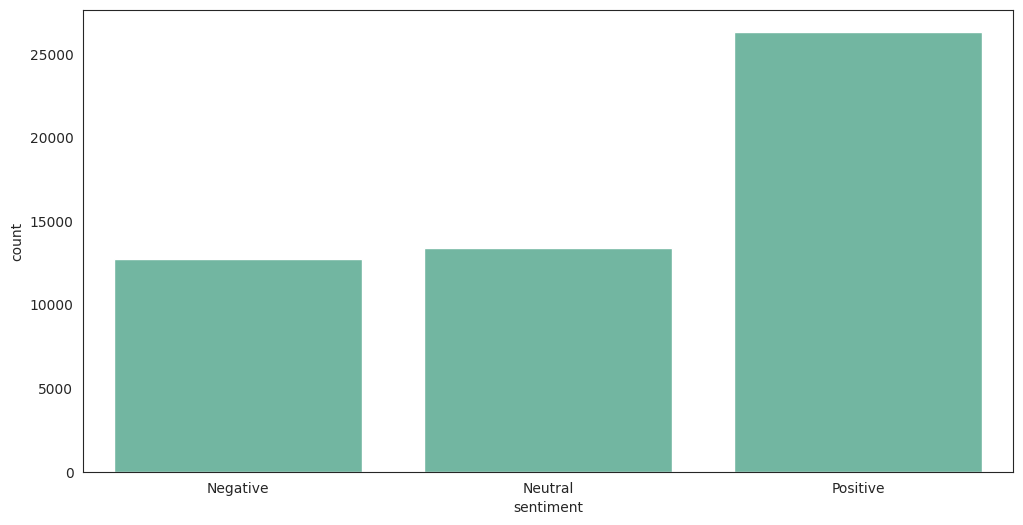

In [27]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)

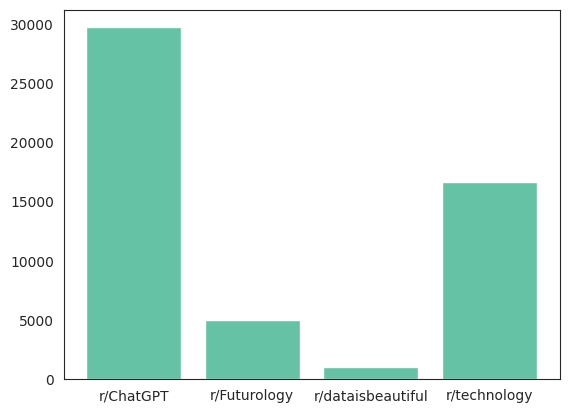

In [28]:
classes, class_counts = np.unique(df['subreddit'].to_numpy(), return_counts = True)
plt.bar(classes, class_counts)
plt.show()

<Figure size 1000x600 with 0 Axes>

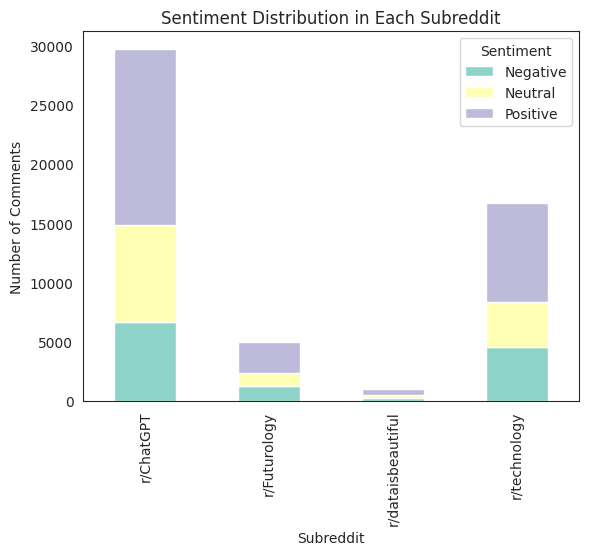

In [29]:
sentiment_counts = df.groupby(['subreddit', 'sentiment']).size().unstack(fill_value=0)
plt.figure(figsize=(10,6))
sns.set_palette("Set3")
sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution in Each Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Number of Comments')
plt.legend(title='Sentiment', bbox_to_anchor=(1,1))
plt.show()

## Classifiers!!!
Here We come!!!

In [30]:
df.isnull().sum()
df.dropna()

,comment_body,subreddit,sentiment
0,"[ive, ben, shock, for, day, now, i, dont, ned,...",r/ChatGPT,Negative
1,"[i, am, so, angri, right, now, i, just, wast, ...",r/ChatGPT,Negative
2,"[chatgpt, karma, whore, is, here, folk, just, ...",r/ChatGPT,Negative
3,"[work, on, me, ngl]",r/ChatGPT,Neutral
4,"[certifi, must, moment, it, reali, did, shock,...",r/ChatGPT,Negative
...,...,...,...
52407,"[problem, is, those, ai, are, gete, le, and, l...",r/technology,Positive
52408,"[that, not, what, i, said, at, al, in, fact, i...",r/technology,Positive
52409,"[re, wikipedia, although, student, have, gete,...",r/technology,Negative
52410,"[scari, thing, is, in, thi, futur, text, won, ...",r/technology,Neutral


In [31]:
df = df.dropna(subset=['sentiment'])
df.isnull().sum()

comment_body    0
subreddit       0
sentiment       0
dtype: int64

In [32]:
X = df['comment_body']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41927,), (10482,), (41927,), (10482,))

# Simple RNN

In [34]:
# using keras tokenizer
from keras.preprocessing import sequence, text
token = text.Tokenizer(num_words = None)
max_len = 1500

token.fit_on_texts(list(X_train))
x_train_seq = token.texts_to_sequences(X_train)
x_test_seq = token.texts_to_sequences(X_test)

#zero pad the sequences, 
x_train_pad = sequence.pad_sequences(x_train_seq, maxlen = max_len)
x_test_pad = sequence.pad_sequences(x_test_seq, maxlen = max_len)

word_index = token.word_index


In [35]:
y_train, y_test

(11028     Neutral
 27330    Negative
 9666      Neutral
 1977     Positive
 31279     Neutral
            ...   
 11284    Negative
 44735    Positive
 38161    Negative
 860      Negative
 15795    Positive
 Name: sentiment, Length: 41927, dtype: object,
 45061    Positive
 42344    Positive
 4264      Neutral
 12883    Negative
 46730    Positive
            ...   
 43418    Positive
 12104    Negative
 47947     Neutral
 18621    Positive
 36070    Negative
 Name: sentiment, Length: 10482, dtype: object)

Label Encoding for Y-train and Y-test for training

In [36]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(["Positive", "Negative", "Neutral"])
y_train = encoder.transform(y_train)

y_test = encoder.transform(y_test)
y_test, y_train

classes = np.unique(y_train)

1. Embedding Layer

    Type: Embedding
    Output Shape: (None, 1500, 300)
    Parameters: 7,374,300

The Embedding layer converts input sequences (in this case, presumably textual data) into dense vectors of fixed size (300 dimensions in this case). The layer is trainable, and the model has a total of 7,374,300 parameters.


2. SimpleRNN Layer

    Type: SimpleRNN
    Output Shape: (None, 100)
    Parameters: 40,100

The SimpleRNN layer is a type of Recurrent Neural Network (RNN) that introduces a form of memory to the network. It processes sequences of data and captures dependencies over time. The layer output shape is (None, 100), indicating 100 units/neurons in the layer.


3. Dense Layer

    Type: Dense
    Output Shape: (None, 3)
    Parameters: 303

The Dense layer is a fully connected layer with 3 output units, corresponding to the three classes (Positive, Negative, Neutral) in sentiment analysis. It performs the final classification based on the features extracted by the previous layers.

In [37]:

%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model_1 = Sequential()
    model_1.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model_1.add(SimpleRNN(100))
    model_1.add(Dense(len(classes), activation='softmax'))
    model_1.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model_1.summary()


2024-02-28 09:00:10.173377: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:10.173550: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         7374300   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 7414703 (28.28 MB)
Trainable params: 7414703 (28.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CPU times: user 1.93 s, sys: 461 ms, total: 2.39 s
Wall time: 1.98 s


In [38]:
x_train_pad.shape, y_train.shape

((41927, 1500), (41927,))

In [39]:
model_1.fit(x_train_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5


2024-02-28 09:00:12.873106: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:12.891570: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:12.910118: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:12.927837: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:12.945755: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:12.963599: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:12.981912: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

 3/82 [>.............................] - ETA: 5s - loss: 1.0784 - accuracy: 0.4225

2024-02-28 09:00:21.003901: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:21.004035: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:21.004140: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:21.004237: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:21.004358: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:21.004584: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:21.004711: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

81/82 [============================>.] - ETA: 0s - loss: 0.9823 - accuracy: 0.5383

2024-02-28 09:00:26.018714: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:26.019019: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-02-28 09:00:26.019148: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


82/82 [==============================] - 18s 129ms/step - loss: 0.9818 - accuracy: 0.5389
Epoch 2/5
82/82 [==============================] - 5s 61ms/step - loss: 0.7944 - accuracy: 0.6620
Epoch 3/5
82/82 [==============================] - 5s 61ms/step - loss: 0.4859 - accuracy: 0.8207


2024-02-28 09:00:41.463045: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


Epoch 4/5
81/82 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.9018

2024-02-28 09:00:46.478671: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


82/82 [==============================] - 5s 61ms/step - loss: 0.2887 - accuracy: 0.9014
Epoch 5/5
82/82 [==============================] - 5s 62ms/step - loss: 0.1681 - accuracy: 0.9471


In [40]:
y_pred_probs = model_1.predict(x_test_pad)
y_pred = y_pred_probs.argmax(axis=1)
y_pred

328/328 [==============================] - 7s 18ms/step


array([2, 1, 2, ..., 2, 2, 0])

In [41]:
np.unique(y_pred)

array([0, 1, 2])

In [42]:
target_names = ["Positive", "Negative", "Neutral"]

In [43]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.34      0.31      0.33      2544
    Negative       0.46      0.48      0.47      2690
     Neutral       0.59      0.61      0.60      5248

    accuracy                           0.50     10482
   macro avg       0.47      0.47      0.47     10482
weighted avg       0.50      0.50      0.50     10482



This model is designed for sentiment analysis using a combination of an embedding layer to convert input sequences, a SimpleRNN layer to capture sequential dependencies, and a Dense layer for final classification. The model's training parameters consist of 7,414,703 trainable parameters. The model achieved an accuracy of 52%, with precision, recall, and F1-score reported for each sentiment class.

# LSTM's

In [44]:
# load the GloVe vectors in a dictionary:
embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


2196018it [03:09, 11618.71it/s]

Found 2196017 word vectors.


In [45]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 24580/24580 [00:00<00:00, 273014.46it/s]


1. Embedding Layer (embedding_1):
   This layer transforms integer indices into dense vectors of fixed size (300 in this case). It's initialized with pre-trained word embeddings.

2. LSTM Layer (lstm):
   Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) layer. It processes sequences and captures long-term dependencies in data.

3. Dense Layer (dense_1):
   Fully connected layer with softmax activation, mapping the LSTM output to three classes (Positive, Negative, Neutral).

In [46]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model_2 = Sequential()
    model_2.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model_2.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model_2.add(Dense(len(classes), activation='softmax'))
    model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1500, 300)         7374300   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 7535003 (28.74 MB)
Trainable params: 160703 (627.75 KB)
Non-trainable params: 7374300 (28.13 MB)
_________________________________________________________________
CPU times: user 1.95 s, sys: 284 ms, total: 2.23 s
Wall time: 1.73 s


In [47]:
model_2.fit(x_train_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5


2024-02-28 09:04:16.876355: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2024-02-28 09:04:17.274092: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


82/82 [==============================] - 23s 192ms/step - loss: 0.9843 - accuracy: 0.5381
Epoch 2/5
82/82 [==============================] - 12s 151ms/step - loss: 0.9342 - accuracy: 0.5710
Epoch 3/5
82/82 [==============================] - 12s 151ms/step - loss: 0.9157 - accuracy: 0.5828
Epoch 4/5
82/82 [==============================] - 12s 151ms/step - loss: 0.9004 - accuracy: 0.5916
Epoch 5/5
30/82 [=========>....................] - ETA: 7s - loss: 0.8885 - accuracy: 0.5994

2024-02-28 09:05:18.261841: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


82/82 [==============================] - 12s 151ms/step - loss: 0.8895 - accuracy: 0.5985


In [48]:
y_pred_1 = model_2.predict(x_test_pad)

2024-02-28 09:05:27.730107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


328/328 [==============================] - 16s 43ms/step


In [49]:
y_pred_1 = y_pred_1.argmax(axis=1)
y_pred_1

array([2, 2, 1, ..., 2, 2, 0])

In [50]:
print(classification_report(y_test, y_pred_1, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.51      0.21      0.30      2544
    Negative       0.59      0.46      0.52      2690
     Neutral       0.60      0.84      0.70      5248

    accuracy                           0.59     10482
   macro avg       0.57      0.50      0.50     10482
weighted avg       0.57      0.59      0.55     10482



The model achieved an accuracy of 58%, with precision, recall, and F1-score reported for each sentiment class. This model utilizes an LSTM layer, which is capable of capturing long-term dependencies in sequential data, potentially making it more effective for sentiment analysis compared to a simple RNN.

The LSTM (Long Short-Term Memory) model is considered an improvement over the Simple RNN (Recurrent Neural Network) for several reasons, mainly addressing the limitations of Simple RNNs. Here are some key aspects in which LSTM is often considered better:

1. Long-Term Dependencies:
        Simple RNN: Struggles to capture long-term dependencies due to the vanishing gradient problem. Gradients diminish exponentially, making it challenging to remember information from distant time steps.
        LSTM: Specifically designed to overcome the vanishing gradient problem. It includes a more sophisticated memory cell that allows it to selectively remember and forget information over long sequences, making it better at capturing long-term dependencies.

2. Memory Cell:
        Simple RNN: Has a simple structure and doesn't have a separate memory cell. It processes each time step independently.
        LSTM: Has a memory cell with a more complex architecture, including input, forget, and output gates. This allows the model to regulate the flow of information into and out of the memory cell, facilitating the storage and retrieval of relevant information over extended sequences.

3. Handling Sequences:
        Simple RNN: Struggles when sequences are long, leading to poor performance on tasks requiring the understanding of context over extended periods.
        LSTM: More effective at learning and retaining information over sequences, making it suitable for tasks involving longer dependencies, such as sentiment analysis where understanding context is crucial.

4. Training Stability:
        Simple RNN: Can suffer from exploding or vanishing gradient problems, making it challenging to train effectively.
        LSTM: Architectural enhancements, including gating mechanisms, help mitigate the gradient problems, leading to more stable training.

5. Parameter Efficiency:
        Simple RNN: May require a large number of parameters to achieve reasonable performance on complex tasks.
        LSTM: Generally more parameter-efficient, as it can capture and reuse relevant information more effectively, requiring fewer parameters to achieve similar or better results.
        
        
Comparison:

1. Parameter Efficiency:
        The LSTM model has a total of 7535003 trainable parameters, while the Simple RNN has 7414703.
        Although the LSTM has more parameters overall, it's noteworthy that a substantial portion comes from the non-trainable embedding layer (7374300 parameters).
        The LSTM's trainable parameters (160400) are higher than the Simple RNN's (40100), indicating a more parameter-rich LSTM layer.

2. Long-Term Dependencies:
        The LSTM's architecture, with memory cells and gating mechanisms, is designed to capture long-term dependencies more effectively.
        Given the performance metrics, the LSTM outperforms the Simple RNN in terms of precision, recall, and F1-score.

3. Training Stability:
        Although the training times provided don't directly indicate stability, the LSTM architecture is generally more resistant to vanishing gradient problems, contributing to more stable training.

Conclusion:

    In this specific context, the LSTM model is better suited for sentiment analysis.
    Despite having more parameters, a significant portion of the LSTM's parameters comes from the non-trainable embedding layer.
    The LSTM's architecture, with its ability to capture long-term dependencies, contributes to better performance metrics compared to the Simple RNN.

# Gated Recurrent Unit

1. Embedding Layer (embedding_2):
   Same as before, transforming integer indices into dense vectors with 300 dimensions.

2. Spatial Dropout1D (spatial_dropout1d):
   Spatial dropout randomly drops entire 1D feature maps, helping prevent overfitting by disrupting spatial correlations in the embeddings.

3. GRU Layer (gru):
   Gated Recurrent Unit (GRU) is another type of recurrent layer that, like LSTM, is capable of capturing long-term dependencies but with a simpler architecture.

4. Dense Layer (dense_2):
   Fully connected layer with softmax activation, mapping the GRU output to three classes (Positive, Negative, Neutral).

In [51]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
     model_3 = Sequential()
     model_3.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model_3.add(SpatialDropout1D(0.3))
     model_3.add(GRU(300))
     model_3.add(Dense(3, activation='softmax'))

     model_3.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1500, 300)         7374300   
                                                                 
 spatial_dropout1d (Spatial  (None, 1500, 300)         0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 300)               541800    
                                                                 
 dense_2 (Dense)             (None, 3)                 903       
                                                                 
Total params: 7917003 (30.20 MB)
Trainable params: 542703 (2.07 MB)
Non-trainable params: 7374300 (28.13 MB)
_________________________________________________________________
CPU times: user 5.89 s, sys: 580 ms, total: 6.47 s
Wall time: 2.47 s


In [52]:
model_3.fit(x_train_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
82/82 [==============================] - 23s 194ms/step - loss: 0.9964 - accuracy: 0.5340
Epoch 2/5
82/82 [==============================] - 13s 155ms/step - loss: 0.9384 - accuracy: 0.5677
Epoch 3/5
82/82 [==============================] - 13s 155ms/step - loss: 0.9114 - accuracy: 0.5848
Epoch 4/5
82/82 [==============================] - 13s 155ms/step - loss: 0.8973 - accuracy: 0.5972
Epoch 5/5
82/82 [==============================] - 13s 155ms/step - loss: 0.8877 - accuracy: 0.6037


In [53]:
y_pred_2 = model_3.predict(x_test_pad)
y_pred_2 = y_pred_2.argmax(axis=1)
y_pred_2

2024-02-28 09:07:04.201061: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


328/328 [==============================] - 14s 39ms/step


array([2, 2, 1, ..., 2, 2, 0])

In [54]:
print(classification_report(y_test, y_pred_2, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.49      0.29      0.37      2544
    Negative       0.60      0.49      0.54      2690
     Neutral       0.61      0.79      0.69      5248

    accuracy                           0.59     10482
   macro avg       0.57      0.52      0.53     10482
weighted avg       0.58      0.59      0.57     10482



1. Parameter Efficiency:
   * The total trainable parameters for Sequential_2 are 542703, which is significantly lower than the LSTM model but higher than the Simple RNN.
   * Non-trainable parameters from the Embedding layer contribute the most to the total parameter count.

2. Handling Long-Term Dependencies:
   * GRU, similar to LSTM, can capture long-term dependencies effectively. The model's performance metrics suggest a good balance between capturing context and avoiding overfitting.

3. Training Stability:
   * The training time is higher than the previous models, likely due to the increased complexity of the GRU layer.

4. Performance Metrics:
   * The Sequential_2 model achieves a higher accuracy (59%) compared to both the Simple RNN (52%) and LSTM (58%) models.
   * It also shows improvements in precision, recall, and F1-score, particularly for the Positive and Negative classes.

Conclusion:

The GRU-based model (Sequential_2) appears to strike a balance between model complexity and performance.
It outperforms both Simple RNN and LSTM in terms of accuracy and other performance metrics.
The model's architecture, including the spatial dropout and GRU layers, contributes to its effectiveness in sentiment analysis.

# Bi-Directional RNN's

1. Embedding Layer (embedding_3):
   Similar to the previous models, transforms integer indices into dense vectors with 300 dimensions.

2. Bidirectional Layer (bidirectional):
   Bidirectional wrapper around the GRU layer. It processes the input sequence both forwards and backward, enhancing the model's ability to capture context from both directions.

3. Dense Layer (dense_3):
   Fully connected layer with softmax activation, mapping the bidirectional GRU output to three classes (Positive, Negative, Neutral).

In [55]:
%%time
with strategy.scope():
    
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model_4 = Sequential()
    model_4.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model_4.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
    model_4.add(Dense(len(classes), activation='softmax'))
    model_4.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1500, 300)         7374300   
                                                                 
 bidirectional (Bidirection  (None, 200)               320800    
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 3)                 603       
                                                                 
Total params: 7695703 (29.36 MB)
Trainable params: 321403 (1.23 MB)
Non-trainable params: 7374300 (28.13 MB)
_________________________________________________________________
CPU times: user 1.04 s, sys: 193 ms, total: 1.23 s
Wall time: 1.12 s


In [56]:
model_4.fit(x_train_pad, y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
82/82 [==============================] - 40s 350ms/step - loss: 0.9803 - accuracy: 0.5392
Epoch 2/5
82/82 [==============================] - 23s 286ms/step - loss: 0.9336 - accuracy: 0.5694
Epoch 3/5
82/82 [==============================] - 23s 286ms/step - loss: 0.9205 - accuracy: 0.5782
Epoch 4/5
82/82 [==============================] - 23s 286ms/step - loss: 0.9023 - accuracy: 0.5914
Epoch 5/5
82/82 [==============================] - 23s 286ms/step - loss: 0.8900 - accuracy: 0.5986


In [57]:
y_pred_3 = model_4.predict(x_test_pad)
y_pred_3 = y_pred_3.argmax(axis=1)
y_pred_3

2024-02-28 09:09:37.922870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


328/328 [==============================] - 27s 76ms/step


array([2, 2, 1, ..., 2, 2, 0])

In [58]:
print(classification_report(y_test, y_pred_2, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.49      0.29      0.37      2544
    Negative       0.60      0.49      0.54      2690
     Neutral       0.61      0.79      0.69      5248

    accuracy                           0.59     10482
   macro avg       0.57      0.52      0.53     10482
weighted avg       0.58      0.59      0.57     10482



1. Parameter Efficiency:
   * The total trainable parameters for Sequential_3 (321403) are lower than both the LSTM and Sequential_2 models, indicating a more parameter-efficient model.

2. Handling Long-Term Dependencies:
   * The bidirectional GRU layer enhances the model's ability to capture long-term dependencies by processing the input sequence in both forward and backward directions.

3. Training Stability:
   * Similar to Sequential_2, the training time is relatively high, likely due to the bidirectional layer's increased complexity.

4. Performance Metrics:
   * Sequential_3 achieves similar performance metrics compared to Sequential_2, with an accuracy of 59% and improved precision, recall, and F1-score for Positive and Negative classes compared to the Simple RNN and LSTM models.

Conclusion:
* The Bidirectional GRU-based model (Sequential_3) combines the advantages of the bidirectional layer with the GRU architecture.
* It achieves competitive performance with fewer trainable parameters, making it more parameter-efficient.
* The choice between Sequential_2 and Sequential_3 depends on factors like computational resources, dataset characteristics, and the desired trade-off between model complexity and performance.
* Both Sequential_2 and Sequential_3 models exhibit similar performance, outperforming the Simple RNN and LSTM models in terms of accuracy and other metrics.

# BERT

In [59]:
!pip3 install ipywidgets --user

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.8 MB/s eta 0:00:00


In [60]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

In [61]:
df_2 = pd.read_csv("/kaggle/input/chatgpt-reddit/chatgpt-reddit-comments.csv")
df_2.dropna(inplace = True)

In [62]:
len(df_1), len(df_2)

(52412, 52412)

In [63]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [64]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

In [65]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [66]:
df_2['sentiment'] = Sentiment_Comment

df_2 = df_2.dropna(subset=['sentiment'])
df_2.isnull().sum()


Unnamed: 0           0
comment_id           0
comment_parent_id    0
comment_body         0
subreddit            0
sentiment            0
dtype: int64

In [67]:
df_1 = df_1.dropna(subset=['sentiment'])
df_1.isnull().sum()

comment_body    0
subreddit       0
sentiment       0
dtype: int64

In [68]:
len(df_1), len(df_2) 

(52409, 52409)

In [69]:
X = df_2["comment_body"]
y = df_1['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)


x_train = fast_encode(X_train, fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(X_test, fast_tokenizer, maxlen=MAX_LEN)


100%|██████████| 41/41 [00:00<00:00, 77.58it/s]


In [70]:
print(x_train.dtype)
print(y_train.dtype)


int64
object


In [71]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(["Positive", "Negative", "Neutral"])
y_train = encoder.transform(y_train)

y_test = encoder.transform(y_test)
y_test, y_train

classes = np.unique(y_train)

In [72]:

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))  # Use the preprocessed y_train
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [73]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [74]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 192)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   134734080 
 stilBertModel)              hidden_state=(None, 192             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 769   

In [75]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=EPOCHS
)

Epoch 1/3


2024-02-28 09:11:27.944243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


327/327 [==============================] - 79s 85ms/step - loss: -52.5715 - accuracy: 0.2553
Epoch 2/3
327/327 [==============================] - 28s 85ms/step - loss: -271.0767 - accuracy: 0.2543
Epoch 3/3
327/327 [==============================] - 27s 84ms/step - loss: -677.5316 - accuracy: 0.2544


In [76]:
y_pred_4 = model.predict(test_dataset)
y_pred_4 = y_pred_4.argmax(axis=1)
y_pred_4

2024-02-28 09:13:29.132198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


82/82 [==============================] - 11s 63ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [77]:
print(classification_report(y_test, y_pred_4, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.24      1.00      0.39      2544
    Negative       0.00      0.00      0.00      2690
     Neutral       0.00      0.00      0.00      5248

    accuracy                           0.24     10482
   macro avg       0.08      0.33      0.13     10482
weighted avg       0.06      0.24      0.09     10482



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
